# Introduction
This notebook contains all the code I have used to define, test and select a machine learning algorithm. The algorithm aims at predicting the status of an Enron employees as <i>poi</i> or <i>non-poi</i>, where <i>poi</i> means Person of Interest, i.e. a person involved in the Enron scandal.
<br>
<br>
The data is taken from the Enron dataset provided in the course.

# Process
The process is articulated in a series of 12 steps. In short, however, what I am doing is not rocket science.
<br>
<br>
I start from the Enron dataset. After having removed outliers and added new features, I split the data into features and labels, using the provided modules.<br>
I then define a list of classifiers that I optimise on the entire population (i.e. I choose the best parameters after running <i>GridSearchCV</i>).<br>
Finally, I validate my classifiers and choose the one with the highest performance metric(s), e.g. <i>f1 score</i>.

### List of steps
The steps I am following are:
<ol>
    <li><b>Import</b> the dataset;</li>
    <li>Define <b>outliers</b>;</li>
    <li>Define <b>new variables/features</b>;</li>
    <li><b>Parse</b> dataset by removing outliers and adding new features;</li>
    <li><b>Keep variables</b> for which percentage of <i>NaN</i> is below a specified threshold;</li>
    <li><b>Remove</b> variables which are highly correlated between each other, and keep only one;</li>
    <li><b>Split data</b> into "Features" and "Labels";</li>
    <li><b>Scale features</b> using MinMax scaler;</li>
    <li>Define <b>list of classifiers</b>;</li>
    <li><b>Optimise parameters</b> of classifiers (on the entire population). I might use pipelines adding PCA or k-best feature selection. Optimisation is performed via GridSearchCV;</li>
    <li><b>Evaluate</b> classifiers, i.e. calculate performance metrics using cross validation.</li>
</ol>
<br>
The best-performing classifier is the one I will select.

#### Importing modules
First of all I import a series of modules I will need over this exercise. Please note that some of the modules have been created by me (e.g. <i>dict_parser</i>) or Udacity (e.g. <i>feature_format</i>). 

In [1]:
# Import standard modules
import pickle
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import time
from collections import OrderedDict


# Import sklearn modules
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.neighbors import KNeighborsClassifier as KNC




# Import user-defined modules
sys.path.append("../tools")
from feature_format import featureFormat, targetFeatureSplit
import dict_parser
import clf_builder
import evaluate
import optimiser as opt

sys.path.append("../scripts")
import tester

### 1. Import the dataset
I start by importing the Enron dataset, stored in a pickle file. I call this file data_dict.

In [2]:
with open("../data/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
df = dict_parser.convert_into_df(data_dict)

In [4]:
df['poi'].sum()

18.0

### 2. Define outliers
I now define a list of outliers I want to remove from the dataset.

In [5]:
outliers = ['TOTAL',
            'SHAPIRO RICHARD S',
            'KAMINSKI WINCENTY J',
            'KEAN STEVEN J',
            'LOCKHART EUGENE E',
            'THE TRAVEL AGENCY IN THE PARK']

### 3. Define new variables

I now define a dictionary specifying the variables I want to add.

In [6]:
# Define adder dictionary for adding new variables
adder_dictionary = {'ratio' : {'exercised_ratio': ['exercised_stock_options',
                                                   'total_stock_value'],
                               'from_poi_ratio' : ['from_poi_to_this_person', 'to_messages'],
                               'to_poi_ratio' : ['from_this_person_to_poi', 'from_messages'],
                               'shared_with_poi_ratio' : ['shared_receipt_with_poi',
                                                          'to_messages']},
                    'additive' : {'wealth' : ['salary',
                                              'total_payments',
                                              'bonus',
                                              'total_stock_value',
                                              'expenses',
                                              'other',
                                              'restricted_stock']}}

### 4. Parse dataset

I now parse the dataset using the <i>parse_dictionary</i> function in the <i>dict_parser</i> module I have created. This function simply retuns a similar dictionary, after having removed outliers, added new variables, and added log and sqrt transformations of selected variables.

In [7]:
# Return parsed data dictionary
my_dataset = dict_parser.parse_dictionary(data_dict,
                                          outliers,
                                          adder_dictionary,
                                          log_sqrt=['wealth', 'exercised_stock_options'])

### 5. Keep variables only if NaN proportion is below a certain threshold
The next chunk extracts the features for which the proportion of <i>NaN</i> values is below a specified certain threshold. By default, this threshold is equal to 0.5.

In [8]:
keep_variables = dict_parser.extract_fields_for_ml(my_dataset)

### 6. Remove variables which are highly correlated

There might be some variables which are highly correlated between each other. In order to avoid redundant information, I might just remove these correlated variables and choose one of them.
<br>
<br>
In order to quickly visualise the correlations, I am going to use a correlation matrix.

In [9]:
# Convert dataset to pandas dataframe
# Please notice that I am slicing the dataframe by using the keep variables only
df = dict_parser.convert_into_df(my_dataset)[keep_variables]

# Create correlation dataframe
corr = df.corr()

In order to create a correlation matrix, I am using a similar code to the one provided [here](https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html).

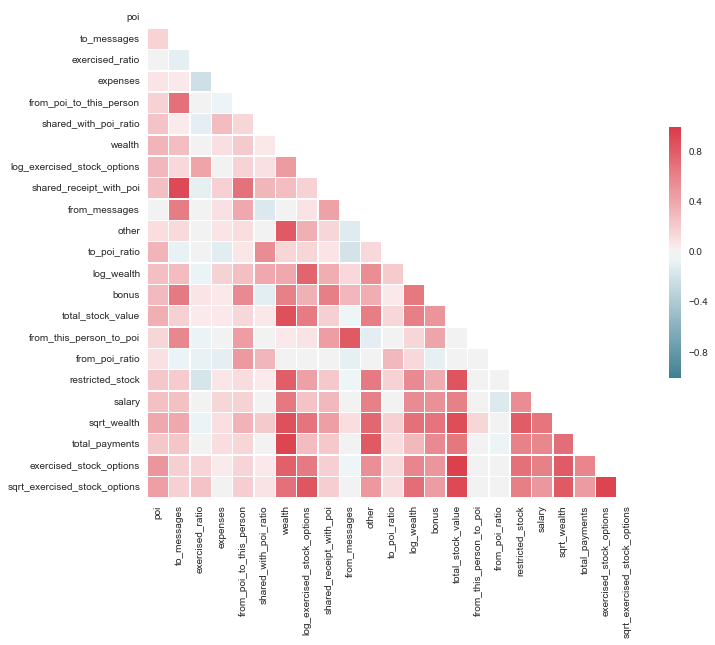

In [10]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Obviously, a variable like <b>wealth</b> is highly correlated with the variables it is the sum of (e.g. restricted_stock, salary, sqrt_wealth, etc.).
<br>
<br>
There are three approach to address a situation like this:
<ul>
    <li><b>manually</b> remove highly correlated values and just pick one;</li>
    <li>selecting the <b>most important features</b> that explain variance in the variable <i>poi</i>;</li>
    <li>use <b>PCA</b> to identify principal components;</li>
</ul>
<br>
Ultimately, PCA would be my <b>favourite choice</b>, but I would also like to remove variables which are somehow duplicates, e.g. <i>sqrt_wealth</i> and <i>log_wealth</i> and just keep one of them. In order to faciliate this choice, I will use <i>SelectKBest</i> (with ANOVA classification, i.e. <i>f_classif</i>).<br>
In order to do that, I firstly need to convert the dataset into arrays of features and labels. I will use the <i>featureFormat</i> function already provided.

### 7. Split data into features and labels
I am extracting features and labels for all variables in the <i>keep_variables</i> list.

In [11]:
data = featureFormat(my_dataset, keep_variables, sort_keys=True)
labels, features = targetFeatureSplit(data)

Going back to paragraph 6, I will now check the importance of features in explaining the variance in the label variable (by using <i>f_classif</i>, i.e. ANOVA, on all the features).

In [12]:
# Extract number of features. Substract 1 since the keep_variables list include also 'poi'
num_features = len(keep_variables) - 1

# Initiate an instance of SelectKBest selector
selector = SelectKBest(score_func=f_classif)

# Fit the selector
selector.fit(features, labels)

# Return a dataframe
best_features = pd.DataFrame(keep_variables[1:],
                            columns = ['feature'])

# Add scores and p-values
best_features['score'] = selector.scores_
best_features['p_value'] = selector.pvalues_

# Order by score
best_features.sort_values(by = 'score', ascending=False)

,feature,score,p_value
18,sqrt_wealth,25.998223,0.000001
20,exercised_stock_options,24.175126,0.000002
13,total_stock_value,23.803037,0.000003
12,bonus,20.444077,0.000013
17,salary,18.857360,0.000027
5,wealth,17.456193,0.000052
10,to_poi_ratio,15.835637,0.000111
21,sqrt_exercised_stock_options,12.471630,0.000562
7,shared_receipt_with_poi,11.483310,0.000916
11,log_wealth,11.217866,0.001045


It is evident how <b>wealth</b> is actually a very important features. Of all three possible wealth features (i.e. actual, sqrt and log transformation), <b>sqrt_wealth</b> has a much higher F score (although the p-value for all of the three is below 5%). Therefore, I will use <i>sqrt_wealth</i> only.
<br><b>Also</b>, sqrt_wealth seems to be highly correlated with other financial features. Let me plot the correlation of <i>sqrt_wealth</i>.



In [13]:
wealth_corr = corr['sqrt_wealth'].copy()

In [14]:
# Simple sequential x axis
x = np.arange(1, len(keep_variables))
y = wealth_corr.values[1:]

LABELS = wealth_corr.index.values

# Array to identify variables whose correlation
# is greater than 0.6. Exclude variable 'poi'
high_corr = np.array(wealth_corr > 0.6)[1:]



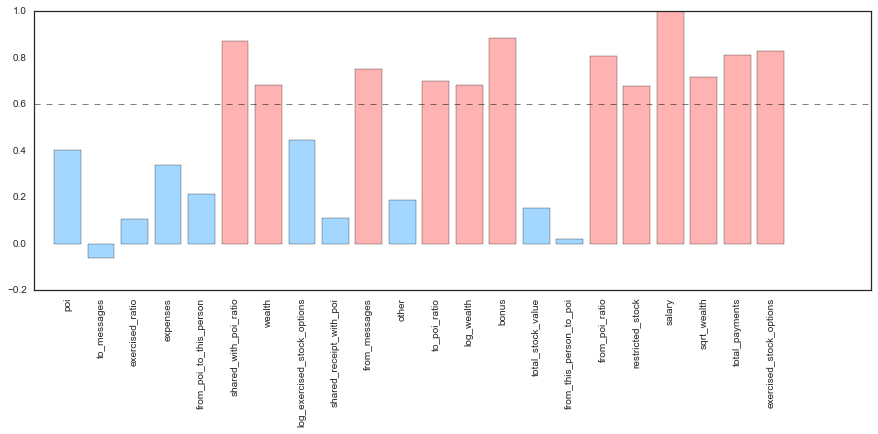

In [15]:
plt.figure(figsize=(15,5))

# Enable drawing of multiple graphs on one plot
plt.hold(True)


# Plot low correlation
plt.bar(x[~high_corr], y[~high_corr], align = 'center', color = '#a3d7ff')

# Plot high correlation
plt.bar(x[high_corr], y[high_corr], align = 'center', color = '#ffb2b2')

# Add labels
plt.xticks(x, LABELS, rotation = 'vertical')
plt.axhline(y = 0.6, color = 'black',
            linewidth = 0.5,
            linestyle = 'dashed')
plt.show()

I therefore remove <i>log_wealth</i> and <i>sqrt_wealth</i> from the list of variables.

In [16]:
# Remove log_wealth and wealth
keep_variables = [x for x in keep_variables if x not in ['wealth', 'log_wealth']]

In addition, I would like to highlight five features which actually have a p-value greater than 5% (in an ANOVA test against leabel features). Two of them are actually variables I have created. Also, three of these variable do actually refer to the concept of 'email sent' (i.e. <i>from_messages</i>, <i>from_this_person_to_poi</i>, and <i>from_poi_ratio</i>).<br>
Let me go through each one of them:
<ul>
    <li><b>from_this_person_to_poi</b>, i.e. the amount of e-mail sent to a POI does not seem be statistically different between POI and non-POI;</li>
    <li><b>from_poi_ratio</b>, i.e. the amount of e-mail sent to a POI (as a ratio to the total amount of email sent) does not seem be statistically different between POI and non-POI;</li>
    <li><b>log_exercised_stock_options</b>, i.e. the log-transformation of the amount (in USD) of stock options which have been exercised;</li>
    <li><b>exercised_ratio</b>, i.e. the amount of stock options exercised (as a ratio to the total amount of stock options);</li>
    <li><b>from_messages</b>, i.e. the total amount of e-mail sent from this person.</li>
</ul>
<br>
Given their low importance, I will remove these variables from the list.

In [17]:
remove = ['from_this_person_to_poi',
          'from_poi_ratio',
          'log_exercised_stock_options',
          'exercised_ratio',
          'from_messages']

keep_variables = [x for x in keep_variables if x not in remove]

#### New features and labels
I am now re-extracting features and labels, using the new <i>keep_variables</i> list.

In [18]:
data = featureFormat(my_dataset, keep_variables, sort_keys=True)
labels, features = targetFeatureSplit(data)

### 8. Scale features using MinMax scaler
Here I am using the MinMax scaler in sklearn. I am going to fit and transform all the features.

In [19]:
# Initialise the scaler
scaler = MinMaxScaler()

# Fit and transform
features = scaler.fit_transform(features)

In the future, <b>however</b>, I will add the scaling as part of a pipeline. This is mainly due to the fact that `tester.py`, i.e. the script used to evaluate this project, does not use scaling by default, so I either had to change the script or add the scaling algorithm to the pipeline. I chose for the latter.

### 9. Define list of classifiers
The algorithms I will use are:
<ul>
    <li>Gaussian Naive Bayes;</li>
    <li>Support Vector Machine (SVM);</li>
    <li>Decision Tree;</li>
    <li>Random Forest;</li>
    <li>Boosted model with AdaBoost;</li>
    <li>Clustering K Nearest Neighbors;</li>
    <li>Clustering BallTree;</li>
    <li>Logistic Regression.</li>
</ul>   

I will create a list of tuples to store information about each classifier. Each tuples will hold a <i>classifier</i>, i.e. an instance of the classifier itself and a dictionary with its parameters.

In [20]:
# Define the list of classifiers
classifiers = []

# Initialise NB classifier. NB does not take any parameter
NB_classifier = GaussianNB()
NB_params = {}
classifiers.append(clf_builder.dict_builder(NB_classifier, NB_params))

# Initialise SVM classifier.
SVM_classifier = SVC(class_weight = 'balanced', probability = True, random_state=42)
SVM_params = {'kernel' : ['linear', 'sigmoid', 'rbf'],
              'gamma' : [10**-4, 10**-3, 10**-2, 10**-1, 10**0,
                     10**1, 10**2, 10**3, 10**4],
              'C' : [10**-4, 10**-3, 10**-2, 10**-1, 10**0,
                     10**1, 10**2, 10**3, 10**4]}
classifiers.append(clf_builder.dict_builder(SVM_classifier, SVM_params))

# Decision Tree
DT_classifier = DTC(class_weight = 'balanced', random_state=42)
DT_params = {'criterion' : ['gini', 'entropy'],
             'max_features' : [2,3,4,5,6,7,8,9,10, None, 'sqrt', 'log2'],
             'min_samples_split' : [2, 5, 10, 15, 20, 25, 30]}
classifiers.append(clf_builder.dict_builder(DT_classifier, DT_params))

# K Nearest Neighbors
KNC_classifier = KNC()
KNC_params = {'n_neighbors' : [3,5,6,7,8,9,10],
              'weights' : ['uniform', 'distance']}
classifiers.append(clf_builder.dict_builder(KNC_classifier, KNC_params))

# Ball Tree
BT_classifier = KNC(algorithm = 'ball_tree')
BT_params = {'n_neighbors' : [3,5,6,7,8,9,10],
              'weights' : ['uniform', 'distance']}
classifiers.append(clf_builder.dict_builder(BT_classifier, BT_params))

# Logistic Regression
LR_classifier = LR(class_weight = 'balanced', random_state=42)
LR_params = {'C' : [10**-4, 10**-3, 10**-2, 10**-1, 10**0,
                     10**1, 10**2, 10**3, 10**4]}
classifiers.append(clf_builder.dict_builder(LR_classifier, LR_params))

#### OOB Errors for ensemble classifiers
For Random Forest, I want to deep dive on the out-of-bag error estimates and check for the number of estimators after which the error seems to stabilize. I am referring to a code I have found [here](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py).
<br>
<br>
It seems that the out-of-bag error stabilizes after 200-250 estimators have been used. Also note that the error is quite small anyway, between 0.135 and 0.145. I am actually pretty happy to use a number of estimator equal to 100.


Processing.............................................
Completed!

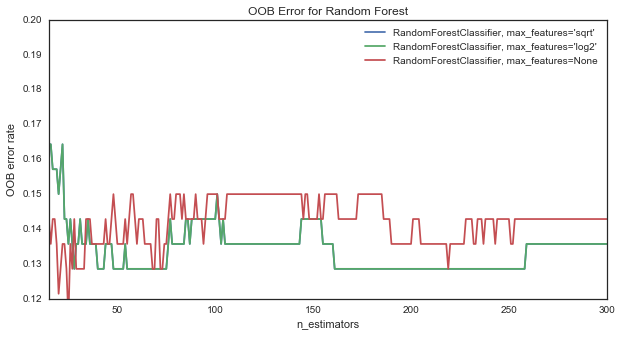

In [21]:
RANDOM_STATE = 42

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RFC(oob_score=True,
            class_weight = 'balanced',
            max_features="sqrt",
            random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RFC(max_features='log2',
            class_weight = 'balanced',
            oob_score=True,
            random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RFC(max_features=None,
            class_weight = 'balanced',
            oob_score=True,
            random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 300
first = True

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(features, labels)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))
        if i % 20 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False

sys.stdout.write('\nCompleted!')
            
# Generate the "OOB error rate" vs. "n_estimators" plot.
f, ax = plt.subplots(figsize=(10,5))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    ax.plot(xs, ys, label=label)


plt.xlim(min_estimators, max_estimators)
plt.ylim(0.12, 0.2)
plt.title('OOB Error for Random Forest')
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [21]:
# Random Forest
RF_classifier = RFC(class_weight='balanced', oob_score = True, n_estimators = 100)
RF_params = {'criterion' : ['gini', 'entropy'],
             'max_features' : [2,3,4,5,6,7,8,9,10, None, 'sqrt', 'log2'],
             'min_samples_split' : [2, 5, 10, 15, 20, 25, 30]}
classifiers.append(clf_builder.dict_builder(RF_classifier, RF_params))

# AdaBoost Classifier
AB_classifier = ABC(n_estimators = 100)
AB_params = {'learning_rate' : [0.5, 0.6, 0.7, 0.75, 1]}
classifiers.append(clf_builder.dict_builder(AB_classifier, AB_params))

### 10. Optimise parameters
Here I will perform optimisation of classifier parameters. I am using the functions defined in `optimiser.py`. I am optimising on <i>f1</i> score.

In [22]:
opt_no_pca = opt.optimise_list(classifiers,
                               features,
                               labels)

GaussianNB in progress...........Completed!
SVC in progress

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


...........Completed!
DecisionTreeClassifier in progress...........Completed!
KNeighborsClassifier in progress...........Completed!
KNeighborsClassifier in progress...........Completed!
LogisticRegression in progress...........Completed!
RandomForestClassifier in progress...........Completed!
AdaBoostClassifier in progress...........Completed!


In [23]:
opt_pca = opt.optimise_list(classifiers,
                            features,
                            labels,
                            pca_bool = True)

GaussianNB in progress...........Completed!
SVC in progress...........Completed!
DecisionTreeClassifier in progress...........Completed!
KNeighborsClassifier in progress...........Completed!
KNeighborsClassifier in progress...........Completed!
LogisticRegression in progress...........Completed!
RandomForestClassifier in progress...........Completed!
AdaBoostClassifier in progress...........Completed!


### 11. Evaluate classifiers
It is time to evaluate the algorithms now. I will use StratifiedShuffleSplit (on 1000 different samples). Part of the code is actually the same as <i>tester.py</i> as provided in the course. I am using the functions defined in the module `evaluate.py`.

In [24]:
clfs_list = opt_no_pca + opt_pca

In [25]:
evaluate.clf_ranking(clfs_list, features, labels)

GaussianNB in progress

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


...........Completed!
SVC in progress...........Completed!
DecisionTreeClassifier in progress...........Completed!
KNeighborsClassifier in progress...........Completed!
KNeighborsClassifier in progress...........Completed!
LogisticRegression in progress...........Completed!
RandomForestClassifier in progress...........Completed!
AdaBoostClassifier in progress...........Completed!
GaussianNB__pca in progress...........Completed!
SVC__pca in progress...........Completed!
DecisionTreeClassifier__pca in progress...........Completed!
KNeighborsClassifier__pca in progress...........Completed!
KNeighborsClassifier__pca in progress...........Completed!
LogisticRegression__pca in progress...........Completed!
RandomForestClassifier__pca in progress...........Completed!
AdaBoostClassifier__pca in progress...........Completed!


,name,accuracy,precision,recall,f1
1,SVC,0.810429,0.456336,0.7885,0.553282
14,RandomForestClassifier__pca,0.824357,0.450733,0.6005,0.485046
2,DecisionTreeClassifier,0.771286,0.382725,0.7445,0.481528
5,LogisticRegression,0.815071,0.422079,0.6160,0.476142
9,SVC__pca,0.762571,0.383110,0.6995,0.467872
13,LogisticRegression__pca,0.778786,0.372953,0.6060,0.435889
10,DecisionTreeClassifier__pca,0.790429,0.346523,0.4660,0.372526
6,RandomForestClassifier,0.858214,0.409200,0.3360,0.348938
7,AdaBoostClassifier,0.837714,0.348571,0.3220,0.315146
8,GaussianNB__pca,0.862000,0.345583,0.2305,0.267133


It seems that SVC is the best classifier. In particular, it has a very high recall, which is something I am interested in since I am trying to - actually - recall as many POF as possible.
<br>
Random Forest (with PCA), Decision Tree and Logistic Regression has also very good classifiers.

#### Optimising for `tester.py`
By looking at the code in `tester.py`, I noticed that this script is evaluating an algorithm globally, i.e. it is measuring true/false positives/negatives and then calculating the various ratios for all predictions.
<br>In my code, I am optimising the classifiers using the `sklearn.metrics` module where metrics are calculated on a specified label position. For binary classifications, the default label is 1, i.e. metrics are calculated (by default) on the 1 value. In other words, the precision, recall, f1, etc. I am optimising the classifiers on are those of POI positive values (I am only looking at the 1s). `tester.py`, on the contrary, is looking at the global (unweighted) performance of the classifiers.
<br>
<br>
In theory, I would like to keep on optimising on POI only (i.e. optimising metrics on poi equal to 1). <b>However</b>, I am conscious that this project is graded by looking at the results of the `tester.py` code. Therefore, I am re-optimising the algorithms on <i>f1_micro</i>, i.e. f1 unweighted global score. I am then using a modified version of the `tester.py` script (similar to `evaluate_clf_list`).

In [26]:
mod_opt_no_pca = opt.optimise_list(classifiers,
                                   features,
                                   labels,
                                   scoring = 'f1_micro')

GaussianNB in progress...........Completed!
SVC in progress...........Completed!
DecisionTreeClassifier in progress...........Completed!
KNeighborsClassifier in progress...........Completed!
KNeighborsClassifier in progress...........Completed!
LogisticRegression in progress...........Completed!
RandomForestClassifier in progress...........Completed!
AdaBoostClassifier in progress...........Completed!


In [27]:
mod_opt_pca = opt.optimise_list(classifiers,
                                features,
                                labels,
                                pca_bool = True,
                                scoring = 'f1_micro')

GaussianNB in progress...........Completed!
SVC in progress...........Completed!
DecisionTreeClassifier in progress...........Completed!
KNeighborsClassifier in progress...........Completed!
KNeighborsClassifier in progress...........Completed!
LogisticRegression in progress...........Completed!
RandomForestClassifier in progress...........Completed!
AdaBoostClassifier in progress...........Completed!


In [28]:
mod_list = mod_opt_no_pca + mod_opt_pca

In [29]:
evaluate.clf_ranking(mod_list, features, labels, tester = True)

GaussianNB in progress...........Completed!
SVC in progress...........Completed!
DecisionTreeClassifier in progress...........Completed!
KNeighborsClassifier in progress...........Completed!
KNeighborsClassifier in progress...........Completed!
LogisticRegression in progress...........Completed!
RandomForestClassifier in progress...........Completed!
AdaBoostClassifier in progress...........Completed!
GaussianNB__pca in progress...........Completed!
SVC__pca in progress...........Completed!
DecisionTreeClassifier__pca in progress...........Completed!
KNeighborsClassifier__pca in progress...........Completed!
KNeighborsClassifier__pca in progress...........Completed!
LogisticRegression__pca in progress...........Completed!
RandomForestClassifier__pca in progress...........Completed!
AdaBoostClassifier__pca in progress...........Completed!


,name,accuracy,precision,recall,f1
5,LogisticRegression,0.815071,0.403538,0.6160,0.487631
13,LogisticRegression__pca,0.771214,0.331087,0.5895,0.424024
2,DecisionTreeClassifier,0.837071,0.424584,0.3955,0.409526
6,RandomForestClassifier,0.859643,0.513208,0.3400,0.409023
7,AdaBoostClassifier,0.837857,0.413239,0.3215,0.361642
8,GaussianNB__pca,0.862000,0.539813,0.2305,0.323055
9,SVC__pca,0.866786,0.607656,0.1905,0.290065
10,DecisionTreeClassifier__pca,0.812500,0.297996,0.2305,0.259938
0,GaussianNB,0.818357,0.303971,0.2105,0.248744
1,SVC,0.860643,0.543210,0.1540,0.239969


In this case, the best performing algoriths are different. Logistic regression (with and without PCA) are significantly better at recalling POI values. Decision Tree (and its ensemble versions) are also good, although the recall is a bit lower. In this case, SVC, although being more precise, is not very good in terms of recall.
<br>
The <i>C</i> parameter of the Logistic Regression above is equal to 10000 (in fairness, a pretty high value, which means that the algorithm aims at classifying all training examples correctly).